# Lab 3 - Part 1: Classification and Grid Search (33 marks)
### Due Date: Monday, March 13 at 12pm

Author: Christopher DiMattia

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

The purpose of this portion of the assignment is to practice following the grid-search workflow: 
- Split data into training and test set
- Use the training portion to find the best model using grid search and cross-validation
- Retrain the best model
- Evaluate the retrained model on the test set

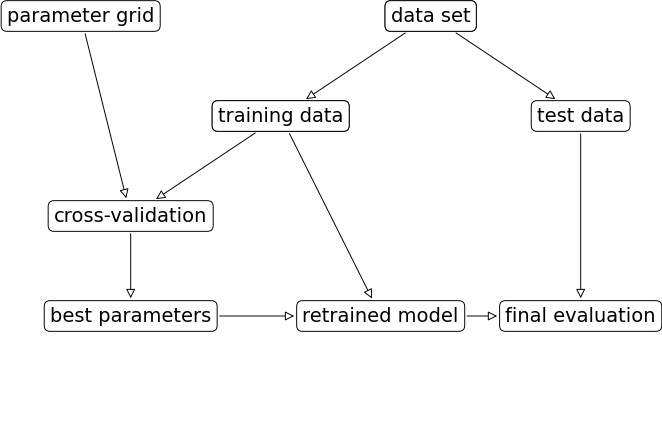

In [11]:
import mglearn
mglearn.plots.plot_grid_search_overview()

## 0. Function definitions (2 marks)

In [12]:
from sklearn.model_selection import cross_validate


def get_classifier_cv_score(model, X, y, scoring='accuracy', cv=7):
    '''Calculate train and validation scores of classifier (model) using cross-validation
        
        
        model (sklearn classifier): Classifier to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        scoring (str): a scoring string accepted by sklearn.metrics.cross_validate()
        cv (int): number of cross-validation folds see sklearn.metrics.cross_validate()
        
        returns: mean training score, mean validation score
    
    '''
    
     #TODO: Implement function body
     #same as lab 2 but with different scoring default
    scores = cross_validate(model, X, y, cv=cv,return_train_score=True,scoring=scoring)
    
    return (scores['train_score'].mean(), scores['test_score'].mean())

    

In [13]:
# DO NOT NEED TO ADD ANYTHING TO THIS FUNCTION
def print_grid_search_result(grid_search):
    '''Prints summary of best model from GridSearchCV object.
    
        For the best model of the grid search, print:
        - parameters 
        - cross-validation training score
        - cross-validation validation score 
        
        scores are printed with 3 decimal places
    
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        returns: None
        
    '''
    
    print(grid_search.best_params_)
    print("training score= {:.3f}; validation score={:.3f}".format(grid_search.cv_results_['mean_train_score'][grid_search.best_index_],
                                                                  grid_search.cv_results_['mean_test_score'][grid_search.best_index_]))

In [14]:
# DO NOT NEED TO ADD ANYTHING TO THIS FUNCTION
import mglearn

def plot_grid_search_results(grid_search):
    '''For grids with 2 hyperparameters, create a heatmap plot of test scores
        
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        uses mglearn.tools.heatmap() for plotting
    
    '''
    results = pd.DataFrame(grid_search.cv_results_)

    params = sorted(grid_search.param_grid.keys())
    
    assert len(params) == 2, "We can only plot two parameters."
    
    # second dimension in reshape are rows, needs to be the fast changing parameter
    scores = np.array(results.mean_test_score).reshape(len(grid_search.param_grid[params[0]]),
                                                      len(grid_search.param_grid[params[1]]))

    # plot the mean cross-validation scores
    # x-axis needs to be the fast changing parameter
    mglearn.tools.heatmap(scores, 
                          xlabel=params[1], 
                          xticklabels=grid_search.param_grid[params[1]], 
                          ylabel=params[0], 
                          yticklabels=grid_search.param_grid[params[0]],
                          cmap="viridis", fmt="%0.3f")

In [15]:
# DO NOT NEED TO ADD ANYTHING TO THIS FUNCTION
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_actual, y_pred, labels, title):
    '''Creates a heatmap plot of the confusion matrix.
    
        y_actual (pandas.DataSeries or numpy.Array): Ground truth label vector
        y_pred (pandas.DataSeries or numpy.Array): Predicted label vector
        labels (list(str)): Class names used for plotting (ticklabels)
        title (str): Plot title
        
        uses sklearn.metrics.confusion_matrix
        
    '''
    
    mat = confusion_matrix(y_actual, y_pred)

    sns.heatmap(mat, 
                xticklabels=labels,  
                yticklabels=labels, 
                square=True, annot=True, cbar=False, 
                fmt='d')
    plt.xlabel('predicted value')
    plt.ylabel('true value')
    plt.title(title)

## 1. Load data (2 marks)
yellowbrick mushroom  
https://www.scikit-yb.org/en/latest/api/datasets/mushroom.html




### 1.1 Prepare the feature matrix and target vector

Using the yellowbrick `load_mushroom()` function, load the mushroom data set into feature matrix `X` and target vector `y`

Print shape and type of `X`, `y`

In [16]:
# TODO: Add data loading code
from yellowbrick.datasets.loaders import load_mushroom

X, y = load_mushroom()

print("X size: " + str(X.size))
print("y size: " + str(y.size))
print("X dimensions: " + str(X.shape))
print("y dimensions: " + str(y.shape))
print("X types:\n" + str(X.dtypes))
print("Y type:" + str(y.dtypes))

X size: 24369
y size: 8123
X dimensions: (8123, 3)
y dimensions: (8123,)
X types:
shape      object
surface    object
color      object
dtype: object
Y type:object


In [17]:
#look at data to get a sense of X feature
display(X)

,shape,surface,color
0,convex,smooth,yellow
1,bell,smooth,white
2,convex,scaly,white
3,convex,smooth,gray
4,convex,scaly,yellow
...,...,...,...
8118,knobbed,smooth,brown
8119,convex,smooth,brown
8120,flat,smooth,brown
8121,knobbed,scaly,brown


In [18]:
#look at target vector to get a sense of data
display(y)

0          edible
1          edible
2       poisonous
3          edible
4          edible
          ...    
8118       edible
8119       edible
8120       edible
8121    poisonous
8122       edible
Name: target, Length: 8123, dtype: object

## 2. Preprocessing (4 marks)
In this dataset, all features are discrete and nominal and need to be encoded. We will use a `OneHotEncoder`

The target vector is discrete and nominal as well and contains string labels. While sklearn is OK using string labels in target vectors, you will use a `LabelEncoder` explicitly to convert strings to integers and keep the encoder to translate between the two representations

### 2.1 Onehot encoding of features
Use `OneHotEncoder` to convert `X` into one-hot-encoded features stored in a variable `X_enc`. Use `sparse=False`. Print shape of `X_enc`

In [19]:
# TODO: Add OneHotEncoder here
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)

X_enc = enc.fit(X).transform(X)

In [20]:
#print X shape
X_enc.shape

(8123, 20)

### 2.2 Label encode target vector 
Use `LabelEncoder` to encode the target vector `y`, saved in a variable `y_enc`

Print the resulting target vector `y_enc` and print the class names available in the `classes_` attribute of the `LabelEncoder` object

In [21]:
#print out class names
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_enc = le.fit(y).transform(y)
le.fit(y).classes_

array(['edible', 'poisonous'], dtype=object)

In [22]:
#print target vector
print(y_enc)

[0 0 1 ... 0 1 0]


## 3. Create training and test sets (1 mark)
Using scikit-learn `train_test_split()` with parameters `random_state=37`, `test_size=0.2`, split `X_enc` and `y_enc` into training and test sets

In [24]:
# TODO: Add train_test_split() here
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, random_state=37, test_size=0.2)

## 4. Compare models using cross-validation (4 marks)
Create a list containing `LogisticRegression()`, 
          `SVC()`,
          `BernoulliNB()`,
        `RandomForestClassifier(random_state=55)`, 
         `GradientBoostingClassifier(random_state=56)` objects.

Iterate this list, then:
- Compute the **f1 score** using `get_classifier_cv_score()` with the 7-fold cross-validation defined above with `X_train` and `y_train` as arguments
- Print the models' training and validation scores with **3 decimal places**

In [25]:
# TODO: Add cross-validation comparison here
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

model_list = [LogisticRegression(),SVC(),BernoulliNB(),RandomForestClassifier(random_state=55),GradientBoostingClassifier(random_state=56)]

for m in model_list:
    result = get_classifier_cv_score(m,X_train,y_train, scoring='f1')
    print("training score " + str(round(result[0],3)) + " validation score: " + str(round(result[1],3)) + " --" + str(m.__class__.__name__))




training score 0.663 validation score: 0.664 --LogisticRegression
training score 0.691 validation score: 0.678 --SVC
training score 0.614 validation score: 0.613 --BernoulliNB
training score 0.692 validation score: 0.678 --RandomForestClassifier
training score 0.702 validation score: 0.692 --GradientBoostingClassifier


## 5. Hyperparameter tuning using grid search (8 marks)

The inital cross-validation above gives us an idea of how algorithms perfom using their default hyperparameters

Next, we will try and improve one model by tuning its hyperparameters using grid search

### 5.1 Grid search for RandomForestClassifier 

Perform grid search using `GridSearchCV` for the `RandomForestClassifier(n_estimators=300, random_state=55)`:

- Set the number of trees `n_estimators=300` for all evaluations
- Grid search using 7-fold cross-validation and `f1` as the scoring function 
- Note that there is a `n_jobs` parameter to run search in parallel. Setting it to the number of CPU cores  or -1 works well

Use the following hyperparameters and values:
- `'max_depth': [3, 5, 8]`
- `'max_features': [0.3, 0.5, 0.7, 0.9]`

From sklearn help:
> - max_depth: The maximum depth of the tree
> - max_features: If float, then max_features is a fraction and max(1, int(max_features * n_features)) features are considered at each split


Use the `print_grid_search_result()` and `plot_grid_search_result()` functions defined above to show the results

In [32]:
# TODO: Setup grid search for RandomForestClassifier(random_state=55)
from sklearn.model_selection import GridSearchCV

param_grid = {  'max_depth' : [3,5,8],
                'max_features' : [0.3,0.5,0.7,0.9] }


grid_search = GridSearchCV(RandomForestClassifier(random_state=55, n_estimators=300),param_grid=param_grid,n_jobs=-1,cv=7,scoring='f1',return_train_score=True)

In [33]:
# TODO: Perform the grid search by calling fit() with X_train and y_train
grid_search.fit(X_train,y_train)


GridSearchCV(cv=7,
             estimator=RandomForestClassifier(n_estimators=300,
                                              random_state=55),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 8],
                         'max_features': [0.3, 0.5, 0.7, 0.9]},
             return_train_score=True, scoring='f1')

In [34]:
# TODO: Call print_grid_search_result() to print the results
print_grid_search_result(grid_search)

{'max_depth': 5, 'max_features': 0.7}
training score= 0.719; validation score=0.716


### *Question 1:* What is the validation score of the best model? Which models in Section 4 does it outperform?

1. The validation score of the best model is 0.716.
2. It outperforms every model in section 4

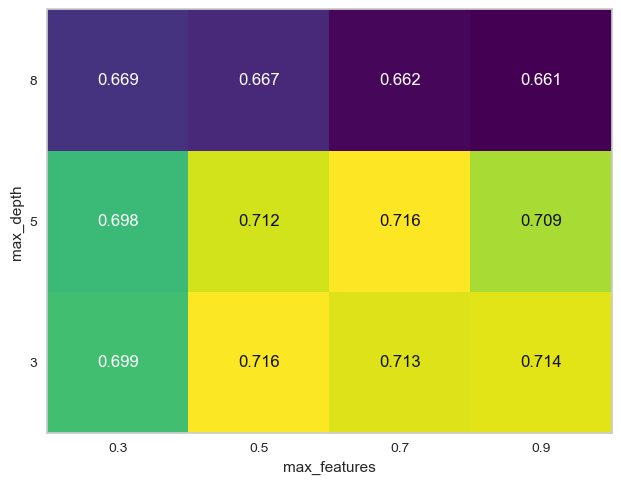

In [35]:
# TODO: Call plot_grid_search_results() to plot validation metrics for all hyperparameter combinations
plot_grid_search_results(grid_search)


### *Question 2:* Where in the hyperparameter ranges does the maximum occur? Would you need to adjust the hyperparameter ranges to find a better model?

1. The maximum validation score is the highest when the max_features and max_depth are (0.7 and 5) or (0.5 and 3).  So roughly the center of max features and lower end of max depth.
2. Not in particular because the best validation scores are fairly close to the center, however you could potentially try and fine tune the max depth and max features by trying slighly different values but it's likely not going to result in a significant difference.


## 6. Re-train best model (2 marks)
Re-train the best `RandomForestClassifier()` from the grid search above on the training dataset `X_train` and `y_train`

In [37]:
#TDOD: Re-train best random forest classifier
best_max_depth = grid_search.best_params_['max_depth']
best_max_features = grid_search.best_params_['max_features']


best_model = RandomForestClassifier(random_state=55, n_estimators=300, max_depth=best_max_depth, max_features= best_max_features)

best_model.fit(X_train,y_train)

RandomForestClassifier(max_depth=5, max_features=0.7, n_estimators=300,
                       random_state=55)

## 7. Evaluate using test data (4 marks)

Using the retrained model and the test dataset `X_test` and `y_test`:
- plot the confusion matrix using the `plot_confusion_matrix()` function defined above
- print the classification report

Make sure the plot has class labels and a title

### 7.1 Confusion matrix and classification report

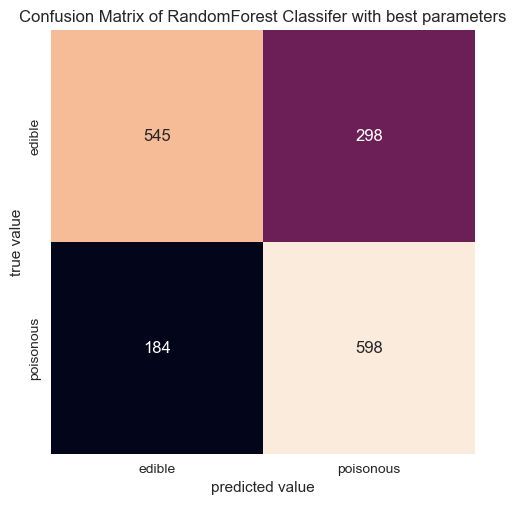

In [39]:
#TODO: call plot_confusion_matrix(), use LabelEncoder classes_ to get labels
plot_confusion_matrix(y_test,best_model.predict(X_test),le.fit(y).classes_,"Confusion Matrix of RandomForest Classifer with best parameters")



### 7.2 Classification report

In [41]:
#TODO: print classification report using default threshold
from sklearn.metrics import classification_report

print(classification_report(y_test,best_model.predict(X_test)))


              precision    recall  f1-score   support

           0       0.75      0.65      0.69       843
           1       0.67      0.76      0.71       782

    accuracy                           0.70      1625
   macro avg       0.71      0.71      0.70      1625
weighted avg       0.71      0.70      0.70      1625



### *Question 3:* What are the precision, recall and accuracy for the positive class on the test set?

1. precision = 545/(545+298) = 0.65
2. recall = 545/(545+184) = 0.75
3. accuracy = (545+598)/(545+298+184+598) = 0.70

### *Question 4:* How many false negatives and false positives does the model produce on the test set?

1. false negative = 184
2. false positive = 298


## 8. Conclusion (4 marks)

In the conclusion, comment on the following items and use data to support your findings:
1. In the classification of edible vs poisonous mushrooms, what do false positive and false negative predictions imply and what are the consequences of making these mistakes?
1. In the classification of edible vs poisonous mushrooms, why is high recall desired?
1. Reflect on the usefulness of this model if it would be put into production and propose ways to improve the model and/or application

1. False positives are extremely dangerous, while false negatives are not dangerous.  This is obivous because a false positive would mean that a mushroom is classified as edible when in fact it's posionous which is extremely dangoues, whereas a false negative (predicated as posionous but really it's edible) isn't dangerous becasue you simply wouldn't eat the mushroom when in fact you could safey.  So unless starvation is at hand a false positive is far more dangerous.
2. A high recall is most important because it identifies the amount of actual positives that are identified correctly.  This number should be close to 1 to be safe.
3. As it stands this model is not very useful because the recall is so low (0.75) which indicates are large amount of incorrectly classified edible mushrooms.  To improve the model we could:
    
    a. gather more data (more features and/or more samples)
    
    b. use a more powerful model such as a neural net

    c. find the best parameters for other models and see if they do any better

    d. If the classifier provides uncertainty estimates then decrease the threshold to increase the recall and therefore make the model safer




## 9. Reflection (2 marks)
Include a sentence or two about:
- what you liked or disliked,
- found interesting, confusing, challangeing, motivating while working on this assignment 

Can include thoughts from Lab 3-2 as well

*ADD YOUR THOUGHTS HERE*



Liked: I liked the sample case used to show how important recall vs precision is.  Typically this only shows up in medical or high impact applications which I don't see much so this assignment felt very useful.  I always enjoy the graphing aspects of ML because it's much easier to visualize the problem and what you are doing than it is to write code.

Dislikes: I found the onehot encoding to be a bit clunky to use at first although that is specific to sklearn.  No dislikes in general.